# Make mask showing all coastal grid cells
Show which grid cells intersect with VI polygon

In [2]:
import geopandas as gpd
import pandas as pd
import movingpandas as mpd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import stats
import seaborn as sns
import xarray as xr
from pyproj import Transformer
from shapely.geometry import Point

import sys
sys.path.append("..")
from src import config
from src.data.load import load_osisaf, load_amsr2
from src.data.process import add_lat_lon_to_amsr

#### Load VI-buffer polygon

In [3]:
vi_gdf = gpd.read_file(config.ADJUSTED_VI_POLY, driver='GeoJSON')

<AxesSubplot:>

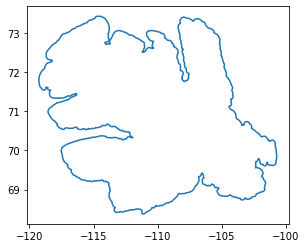

In [4]:
vi_gdf.exterior.plot()

# OSI-SAF / IceNet grids

In [5]:
example_grid = load_osisaf(config.PATH_TO_OSISAF, pd.to_datetime("2021-01-01"))
gulf_grid = example_grid.sel(
    xc=slice(*config.osisaf_plot_config['crop_x']),
    yc=slice(*config.osisaf_plot_config['crop_y']))

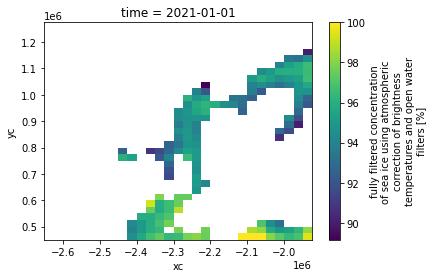

In [6]:
gulf_grid.plot()

Convert to dataframe (pixel centre points)

In [7]:
gulf_df = gulf_grid.to_dataframe()
gulf_gdf = gpd.GeoDataFrame(
    gulf_df.ice_conc, geometry=gpd.points_from_xy(gulf_df.lon,gulf_df.lat), crs="epsg:4326")

In [8]:
gulf_df

time         lon        lat  ice_conc
yc        xc                                                    
1262500.0 -2637500.0 2021-01-01 -115.579178  63.568974       NaN
          -2612500.0 2021-01-01 -115.792320  63.776535       NaN
          -2587500.0 2021-01-01 -116.008797  63.983627       NaN
          -2562500.0 2021-01-01 -116.228683  64.190247       NaN
          -2537500.0 2021-01-01 -116.452042  64.396378       NaN
...                         ...         ...        ...       ...
462500.0  -2037500.0 2021-01-01 -102.789070  71.203346     98.03
          -2012500.0 2021-01-01 -102.942627  71.424721     97.18
          -1987500.0 2021-01-01 -103.099846  71.645874     96.42
          -1962500.0 2021-01-01 -103.260857  71.866814     96.83
          -1937500.0 2021-01-01 -103.425812  72.087532     99.46

[957 rows x 4 columns]

Plot data

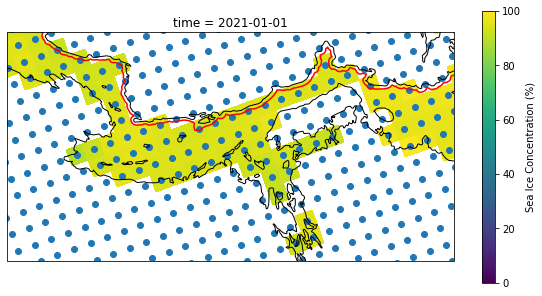

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=config.PROJECTION)

gulf_grid.plot(
    transform=config.osisaf_crs,
    vmin=0,
    vmax=100,
    cbar_kwargs={"label": "Sea Ice Concentration (%)"},
    ax=ax
)

vi_gdf.to_crs(config.PROJECTION, inplace=True)
vi_gdf.exterior.plot(ax=ax, marker="x", color="red")
gulf_gdf.to_crs(config.PROJECTION, inplace=True)
gulf_gdf.plot(ax=ax)
ax.set_extent([-117.0, -103.0, 66.5, 69.5])
ax.coastlines("10m")
plt.show()

#### Iterate over polygon points and find nearest centroid from grid dataframe

In [ ]:
closest_match = []

# create zero array to save per year results
crossing_cell_mask = xr.zeros_like(example_grid)

for i, coord in enumerate(vi_gdf.exterior.iloc[0].coords):
    lon = coord[0]
    lat = coord[1]

    # Find nearest centroid
    abslat = np.abs(gulf_gdf.geometry.y - lat)
    abslon = np.abs(gulf_gdf.geometry.x - lon)
    c = np.maximum(abslon, abslat)

    match = c[c== np.min(c)].index
    closest_match.append([match[0][0], match[0][1]])

    crossing_cell_mask.loc[match[0]] += 1

crossing_cell_mask.to_netcdf(f"{config.PROJECT_PATH}/data/masks/osisaf_coastal_gridcells.nc")

### Example of loading and plotting crossing mask

In [9]:
mask_xr = xr.open_mfdataset(f"{config.OSISAF_COAST_CELLS}").load()

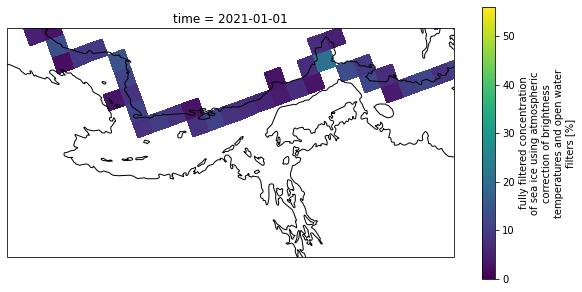

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=config.PROJECTION)

mask = mask_xr.ice_conc
mask.where(mask !=0).plot(
    transform=config.osisaf_crs,
    vmin=0,
    ax=ax,
)
ax.set_extent([-117.0, -103.0, 66.5, 69.5])
ax.coastlines("10m")
plt.show()

# AMSR2 grid

In [21]:
vi_gdf = gpd.read_file(config.ADJUSTED_VI_POLY, driver='GeoJSON')

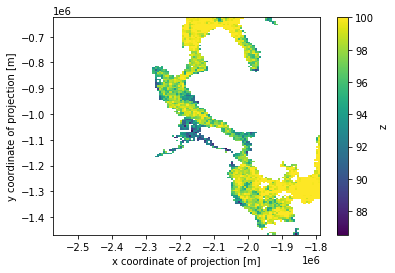

In [22]:
example_grid = load_amsr2(config.PATH_TO_AMSR2, pd.to_datetime("2021-01-01"))
example_grid = add_lat_lon_to_amsr(example_grid.z)
gulf_grid = example_grid.sel(
    x=slice(*config.amsr_plot_config['crop_x']),
    y=slice(*config.amsr_plot_config['crop_y']))

gulf_grid.plot()

In [23]:
gulf_df = gulf_grid.to_dataframe()
gulf_gdf = gpd.GeoDataFrame(
    gulf_df.z, geometry=gpd.points_from_xy(gulf_df.lon,gulf_df.lat), crs="epsg:4326")

Plot data

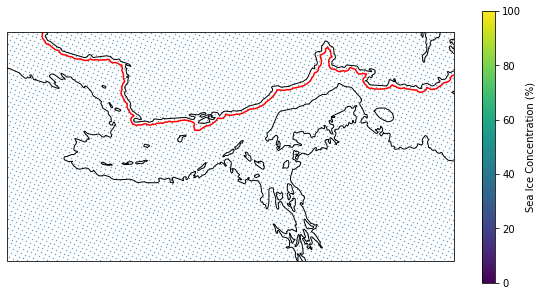

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=config.PROJECTION)

gulf_grid.plot(
    transform=config.osisaf_crs,
    vmin=0,
    vmax=100,
    cbar_kwargs={"label": "Sea Ice Concentration (%)"},
    ax=ax
)

vi_gdf.to_crs(config.PROJECTION, inplace=True)
vi_gdf.exterior.plot(ax=ax, marker="x", color="red")
gulf_gdf.to_crs(config.PROJECTION, inplace=True)
gulf_gdf.plot(ax=ax, markersize=0.1)
ax.set_extent([-117.0, -103.0, 66.5, 69.5])
ax.coastlines("10m")
plt.show()

In [ ]:
closest_match = []

# create zero array to save per year results
crossing_cell_mask = xr.zeros_like(example_grid)

for i, coord in enumerate(vi_gdf.exterior.iloc[0].coords):
    lon = coord[0]
    lat = coord[1]

    # Find nearest centroid
    abslat = np.abs(gulf_gdf.geometry.y - lat)
    abslon = np.abs(gulf_gdf.geometry.x - lon)
    c = np.maximum(abslon, abslat)

    match = c[c== np.min(c)].index
    closest_match.append([match[0][0], match[0][1]])

    crossing_cell_mask.loc[match[0]] += 1
    
crossing_cell_mask.to_netcdf(f"{config.PROJECT_PATH}/data/masks/amsr_coastal_gridcells.nc")

### Example loading and plotting mask

In [14]:
mask_xr = xr.open_mfdataset(f"{config.AMSR_COAST_CELLS}").load()

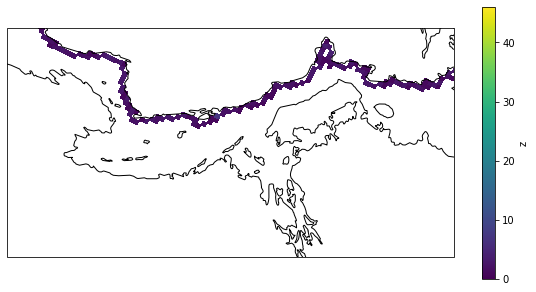

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=config.PROJECTION)

mask = mask_xr.z
mask.where(mask !=0).plot(
    transform=config.amsr_crs,
    vmin=0,
    ax=ax,
)
ax.set_extent([-117.0, -103.0, 66.5, 69.5])
ax.coastlines("10m")
plt.show()